In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
mol = "H2S"
mol_path = f'../{mol}'
tables = '../tables'

In [3]:
pred_df = pd.read_csv(f'{mol_path}/pred_polar_{mol}.csv')

In [1088]:
if pred_df.pred_polar_x[0] > 1:
    pred_df = pred_df/1000
pred_df

,pred_polar_x,pred_polar_y,pred_polar_z
0,0.041919,0.111400,0.057708
1,0.042043,0.111826,0.057867
2,0.042166,0.112178,0.058003
3,0.042282,0.112407,0.058101
4,0.042386,0.112476,0.058148
...,...,...,...
19995,0.042996,0.064798,0.104026
19996,0.043097,0.064721,0.103500
19997,0.043214,0.064653,0.103002
19998,0.043357,0.064614,0.102565


### Derivatives

In [1089]:
try:
    time_df = pd.read_table(f'{mol_path}/time_temp_data_modif', sep='\s+', names=['time', 'temp'])
    new_time = time_df.time - time_df.time[0]
    print('Mean timestep', np.mean(np.diff(time_df.time)))
except:
    timestep = 0.0014
    new_time = pd.Series([round(timestep + timestep * i, 6) for i in range(pred_df.shape[0])], name='time')
    time_steps = new_time

In [1090]:
pred_polar_time = pd.concat([new_time, pred_df], axis=1)
# pred_polar_time.to_csv(f'./CO2/CO2_time_polar.csv', index=False)
pred_polar_time

,time,pred_polar_x,pred_polar_y,pred_polar_z
0,0.0014,0.041919,0.111400,0.057708
1,0.0028,0.042043,0.111826,0.057867
2,0.0042,0.042166,0.112178,0.058003
3,0.0056,0.042282,0.112407,0.058101
4,0.0070,0.042386,0.112476,0.058148
...,...,...,...,...
19995,27.9944,0.042996,0.064798,0.104026
19996,27.9958,0.043097,0.064721,0.103500
19997,27.9972,0.043214,0.064653,0.103002
19998,27.9986,0.043357,0.064614,0.102565


In [1091]:
deriv_x = pred_polar_time.iloc[:, :2]
deriv_x['deriv'] = deriv_x['pred_polar_x'].diff() / deriv_x['time'].diff()
deriv_x

,time,pred_polar_x,deriv
0,0.0014,0.041919,NaN
1,0.0028,0.042043,0.088768
2,0.0042,0.042166,0.087878
3,0.0056,0.042282,0.082671
4,0.0070,0.042386,0.074824
...,...,...,...
19995,27.9944,0.042996,0.065301
19996,27.9958,0.043097,0.071921
19997,27.9972,0.043214,0.084111
19998,27.9986,0.043357,0.101931


In [1053]:
deriv_x.to_csv(f'{tables}/{mol}_deriv_x.csv', index=False)

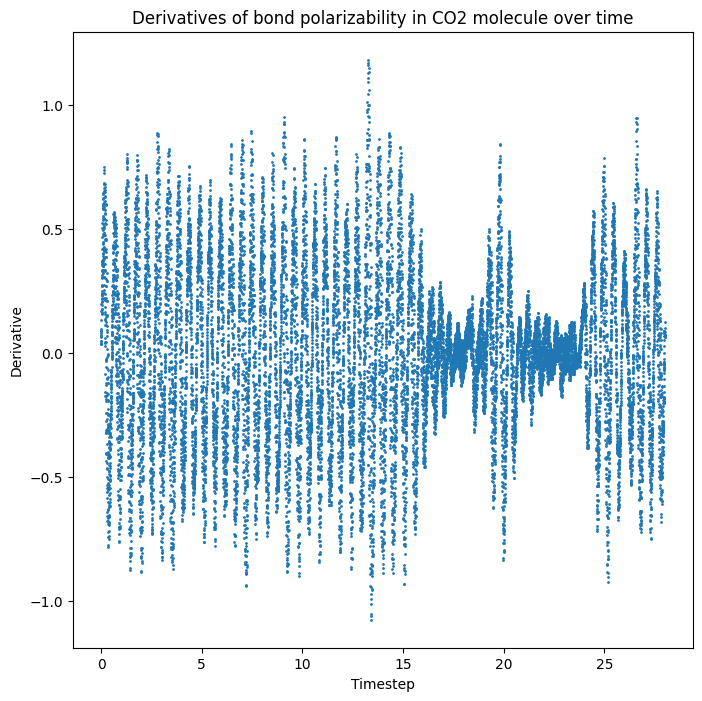

In [1092]:
fig, ax = plt.subplots(figsize=(8,8));
scatter = ax.scatter(x=deriv_x.time, y=deriv_x.deriv, s=1);
# scatter = ax.scatter(x=time_steps, y=autocorr, s=0.5); ### For all axis polarization
plt.title(f"Derivatives of bond polarizability in {mol} molecule over time");
plt.ylabel('Derivative');
plt.xlabel('Timestep');
# plt.show()
plt.savefig(f'../images/{mol}_derivs.png')

### Autocorrelation

In [1093]:
# Numpy 1
def autocorrelation1(data):
    mean = np.mean(data)
    var = np.var(data)
    ndata = data - mean
    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)
    return acorr


def autocorrelation2(data):
    xp = (data - np.mean(data))/np.std(data)
    result = np.correlate(xp, xp, mode='full')
    return result[result.size//2:]/len(xp)

In [1094]:
acorr = autocorrelation1(deriv_x.deriv[1:])
# acorr = autocorrelation2(deriv_x.deriv[1:])

In [1095]:
len(acorr)

19999

In [939]:
# timestep = 0.00145
# time_steps = [round(timestep + timestep * i, 6) for i in range(len(acorr))]

In [1097]:
df_acorr = pd.DataFrame({'timestep': time_steps[1:], 'accor': acorr})
df_acorr

,timestep,accor
1,0.0028,1.000000
2,0.0042,0.982548
3,0.0056,0.932715
4,0.0070,0.857654
5,0.0084,0.768091
...,...,...
19995,27.9944,0.000015
19996,27.9958,0.000014
19997,27.9972,0.000011
19998,27.9986,0.000009


In [1099]:
# df_acorr.to_csv(f'{mol}_acorr_sep.csv', index=False, sep=' ')

In [1059]:
acorr.shape

(16551,)

#### IF we use all axis (not only X-axis)

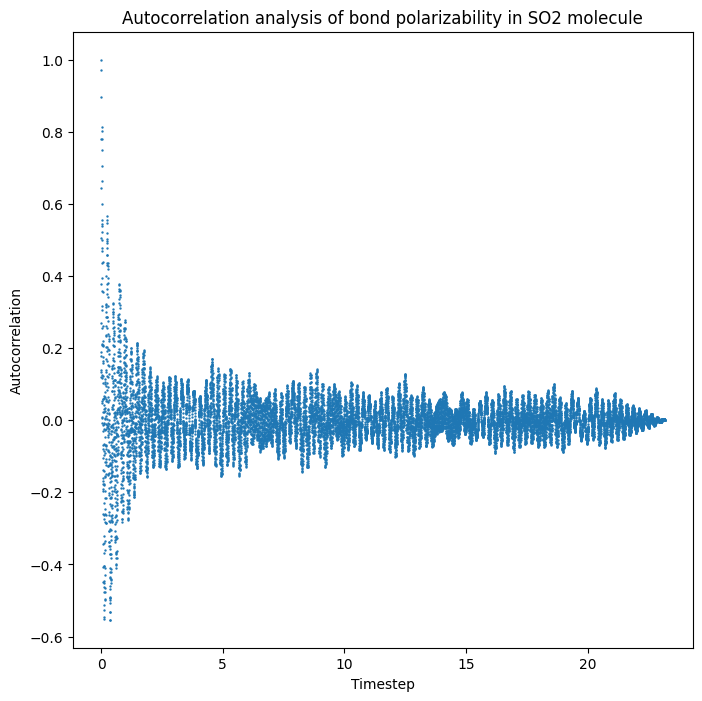

In [1060]:
fig, ax = plt.subplots(figsize=(8,8));
scatter = ax.scatter(x=time_steps[1:], y=acorr, s=0.5);
# scatter = ax.scatter(x=time_steps, y=autocorr, s=0.5); ### For all axis polarization
plt.title(f"Autocorrelation analysis of bond polarizability in {mol} molecule");
plt.ylabel('Autocorrelation');
plt.xlabel('Timestep');
# plt.show()
plt.savefig(f'../images/{mol}_autocorr.png')

In [1061]:
temp = 300
kb = 1.38064852E-23
reduced_planck = 1.05457180013E-34
lightspeed = 299792458

wavelen = 5.32E-7 #(nm -> m)
wavelen_nm = 532
# wavelen = 7.85E-7 #(nm -> m)
omega_in = 2 * np.pi * lightspeed / wavelen
# omega_in = 45.613245464 / wavelen
# timestep = 0.0012 ## ideally
timestep = 0.00145

In [1062]:
omega_in

3540698434791077.0

In [1040]:
from scipy import fftpack
from scipy.fftpack import fft, fftfreq

In [1085]:
df

,timestep,accor
1,0.0028,1.000000
2,0.0042,0.972724
3,0.0056,0.895541
4,0.0070,0.780650
5,0.0084,0.644807
...,...,...
16547,23.1672,0.000323
16548,23.1686,0.000255
16549,23.1700,0.000198
16550,23.1714,0.000142


In [1064]:
TO_CM_1 = 2 * np.pi * 100
size = df.shape[0]

fft_autocorrelation = fft(acorr)[1:]
# fft_autocorrelation = np.fft.fft(acorr)[1:]


freqs_ps = np.fft.fftfreq(size, d=timestep)[1:]
freqs_cm1 = freqs_ps * TO_CM_1
freqs = freqs_cm1

# freqs = np.fft.fftfreq(size, d=timestep)[1:]
# freqs = fftfreq(size, d=timestep)[1:]


fft_autocorrelation = fft_autocorrelation / size

raman_intensity = (
    (omega_in - freqs) ** 4
    / freqs
    / (1 - np.exp(-(freqs * reduced_planck) / (kb * temp))) * fft_autocorrelation.real
)

3.540698434791077

16550


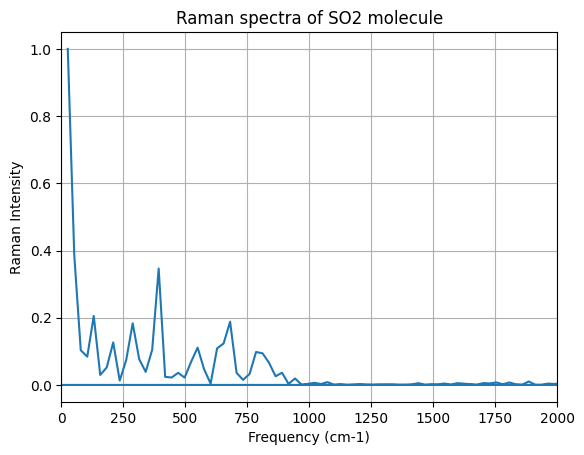

In [1084]:
size = len(raman_intensity)
# size = 100

print(size)

raman_intensity = raman_intensity/ max(raman_intensity)
plt.figure();
# plt.vlines(x=freqs[:size], ymin=0, ymax=raman_intensity[:size])
plt.plot(freqs[:size], raman_intensity[:size])
plt.title(f"Raman spectra of {mol} molecule");
plt.xlabel("Frequency (cm-1)")
plt.ylabel("Raman Intensity")
# plt.xlim([-2000, 2000])
# plt.xlim([1000, 1500])
plt.xlim([0, 1400])
plt.grid()
plt.show()
# plt.savefig(f'../images/{mol}_raman.png')

### proper apodization, windowing

#### The mismatch between computed and experimental frequencies might come from reasons mentioned before: choice of functional, the basis set/pseudopotential... One aspect is the size of the trajectory and the proper sampling of the ensamble. I am not sure a single molecule at 300 K would yield a great result.

#### You could double check your implementation not computing the Raman intensity but the vibrational density of states (the spectrum of the velocity autocorrelation function). If your trajectory/code is working properly, the integrate spectrum should converge to the simulation temperature (or a value close to it).